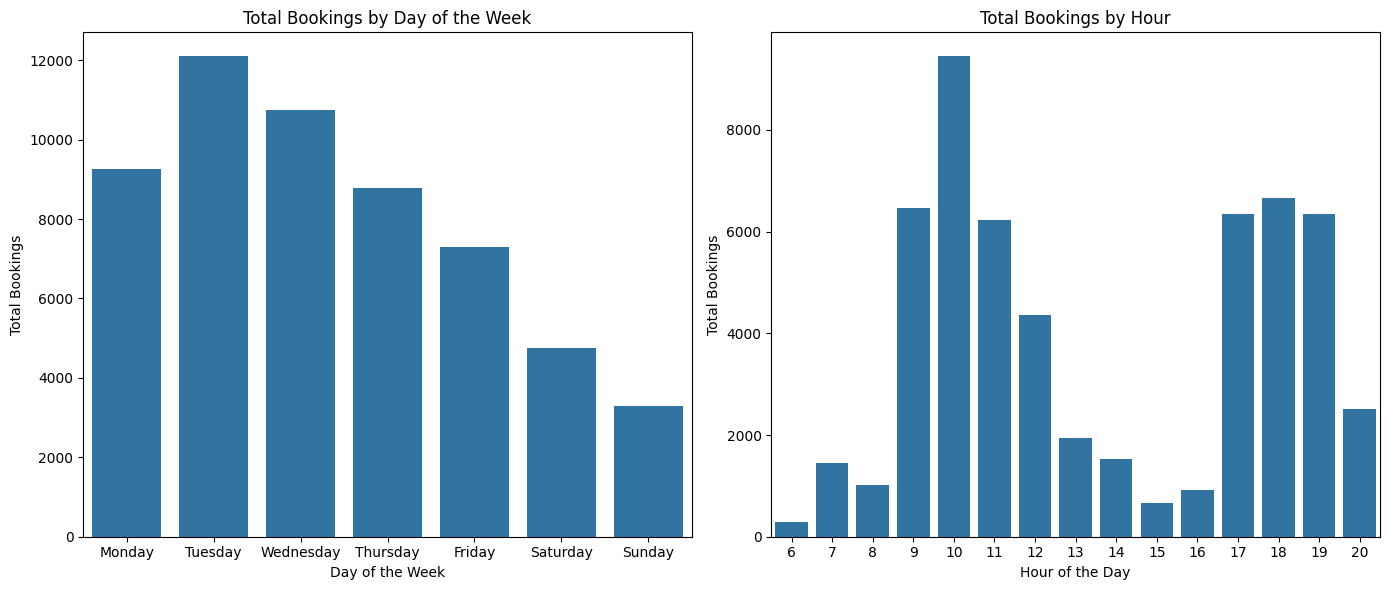

            Class Name  Price (INR)  Adjusted Price (INR)  Number Booked  \
BookingDate                                                                
2018-04-08   20-20-20           499                424.15             12   
2018-04-15   20-20-20           499                424.15             15   
2018-04-22   20-20-20           499                424.15             14   
2018-04-29   20-20-20           499                424.15              9   
2018-05-06   20-20-20           499                424.15              7   

             MaxBookees  DayOfWeek  Hour ActivitySiteID  
BookingDate                                              
2018-04-08           25          6    14            HXP  
2018-04-15           25          6    14            HXP  
2018-04-22           25          6    14            HXP  
2018-04-29           25          6    14            HXP  
2018-05-06           25          6    14            HXP  


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the cleaned data
merged_df = pd.read_csv("C:/Users/gulat/Documents/Cult internship/Cleaned_datasets/Csv data/Cleaned.csv")

# Rename and convert date columns
merged_df.rename(columns={'BookingEndDateTime (Day/Month/Year)': 'BookingDate'}, inplace=True)
merged_df['BookingDate'] = pd.to_datetime(merged_df['BookingDate'], dayfirst=True)
merged_df.set_index('BookingDate', inplace=True)

# Add DayOfWeek and Hour columns
merged_df['DayOfWeek'] = merged_df.index.dayofweek
merged_df['Hour'] = pd.to_datetime(merged_df['BookingStartTime'], format='%I:%M %p').dt.hour

# Summarize and visualize booking data by day of the week and hour
day_of_week_bookings = merged_df.groupby('DayOfWeek')['Number Booked'].sum()
hourly_bookings = merged_df.groupby('Hour')['Number Booked'].sum()

plt.figure(figsize=(14, 6))

#bookings by day of the week
plt.subplot(1, 2, 1)
sns.barplot(x=day_of_week_bookings.index, y=day_of_week_bookings.values)
plt.title('Total Bookings by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Bookings')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

#bookings by hour
plt.subplot(1, 2, 2)
sns.barplot(x=hourly_bookings.index, y=hourly_bookings.values)
plt.title('Total Bookings by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Bookings')

plt.tight_layout()
plt.show()

# Define the pricing adjustment rules
def adjust_prices(row):
    # Initial price
    price = row['Price (INR)']
    
    # Priority 1: Location-based adjustment
    if row['ActivitySiteID'] == 'BRP':
        price *= 1.10  # Increase by 10% for 'BRP' centre
        return price
    elif row['ActivitySiteID'] == 'TSC':
        price *= 0.90  # Decrease by 10% for 'TSC' centre
        return price
    
    # Priority 2: Class-based adjustment
    popular_classes = ['Body Conditioning', 'Studio Cycling', 'Pilates', 'Body Combat', 'Yoga', 'Aquafit']
    if row['Class Name'] in popular_classes:
        price *= 1.15  # Increase by 15% for popular classes
        return price
    elif row['Number Booked'] <= 50:
        price *= 0.85  # Decrease by 15% for classes with bookings <= 50
        return price
    
    # Priority 3: Time-based adjustment
    if ((row['Hour'] in [9, 10, 11, 12, 17, 18, 19]) and (row['DayOfWeek'] < 5)):
        price *= 1.15  # Increase by 15% for specific times on weekdays
        return price
    elif row['DayOfWeek'] >= 5:
        price *= 0.85  # Decrease by 15% for weekends
        return price
    
    # Priority 4: Popularity-based adjustment
    if row['Number Booked'] / row['MaxBookees'] < 0.5:
        price *= 0.85  # Decrease by 15% if bookings < 50% of max
        return price
    elif row['Number Booked'] / row['MaxBookees'] >= 0.5:
        price *= 1.15  # Increase by 15% if bookings >= 50% of max
        return price
    
    return price

# Apply the pricing adjustments
merged_df['Adjusted Price (INR)'] = merged_df.apply(adjust_prices, axis=1)

# Preview the adjusted prices
print(merged_df[['Class Name', 'Price (INR)', 'Adjusted Price (INR)', 'Number Booked', 'MaxBookees', 'DayOfWeek', 'Hour', 'ActivitySiteID']].head())

merged_df.to_csv('C:/Users/gulat/Documents/Cult internship/Dynamic_price.csv',index=False)

